# Import libraries

In [1]:
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1
!pip install -r requirements.txt
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Writing requirements.txt


In [2]:
!pip install keras-cv
import keras_cv

In [21]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
#from tensorflow import keras as tfk
import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
from keras.layers import Input, Dense, Dropout, Lambda
#from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl


from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print("TF version:",tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

TF version: 2.16.1


In [4]:
# Define input and output dimensions
input_shape = (96, 96, 3)
output_shape = 8
learning_rate = 0.001
batch_size = 128
epochs = 100

# Initialise configuration for convolutional layers
stack = 1
filters = 32
kernel_size = 3

In [5]:
def plot_images(images, num=9):
    plt.figure(figsize=(8, 8))
    for i in range(num):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(cm)))
    disp.plot(cmap='viridis', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

# Load the Data

In [6]:
#Load the dataset from the .npz file and take "images" and "labels"
data = np.load('/kaggle/input/aaaaaaa/training_set_without_outlier.npz')
print(data.files)

images = data['images']
labels = data['labels']
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#Shuffle the data
indices = np.random.permutation(len(images))
shuffled_images = images[indices]
shuffled_labels = labels[indices]

#Free a bit of memory
del data
del images
del labels
del indices

['images', 'labels']
Images shape: (11959, 96, 96, 3)
Labels shape: (11959, 1)


# Process Data

In [7]:
#Normalization of images and categorical format for labels
normalized_images = shuffled_images / 255.0
categorical_labels = to_categorical(shuffled_labels).astype('float32')

In [8]:
# Split data into Training set and Validation set
X_train, X_val, y_train, y_val = train_test_split(normalized_images, categorical_labels, test_size=0.2, stratify=categorical_labels)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training set shape: (9567, 96, 96, 3)
Validation set shape: (2392, 96, 96, 3)
Training labels shape: (9567, 8)
Validation labels shape: (2392, 8)


First 9 original images:


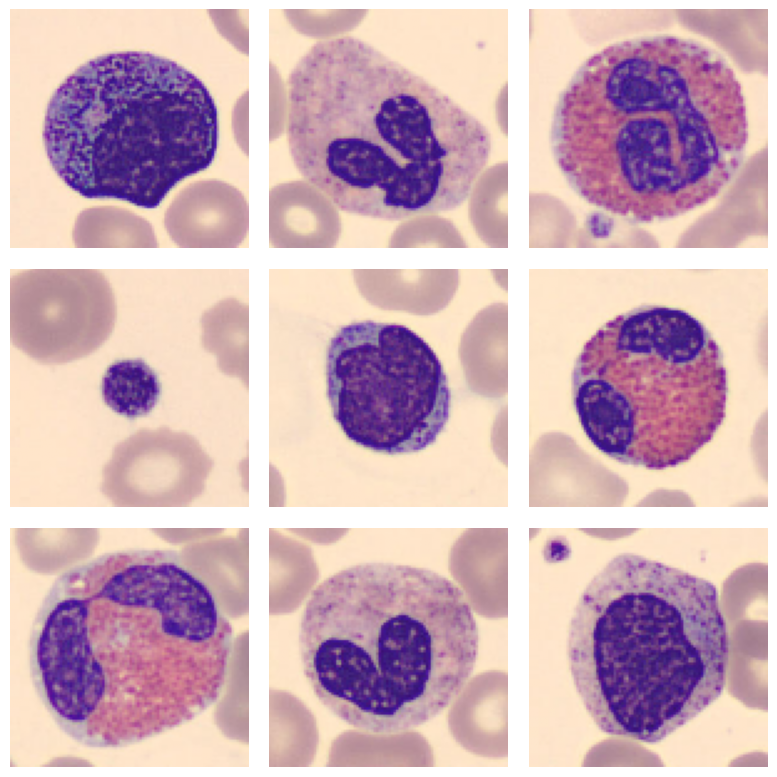

In [9]:
print("First 9 original images:")
plot_images(normalized_images, num=9)

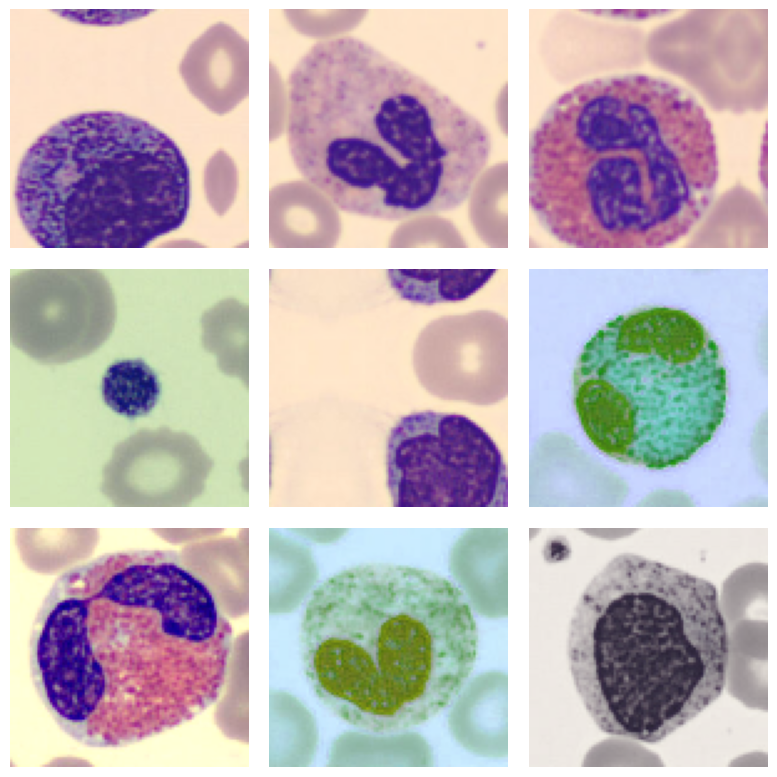

In [10]:
#Through Keras_cv we define a random pipeline of augmentations
data_augmentation = keras_cv.layers.RandomAugmentationPipeline(
    layers=[
        keras_cv.layers.RandomContrast(factor=0.8, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomHue(factor=(0.8,1.0), value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomSharpness(factor = 1, value_range=(0.0, 1.0), seed=seed),
        keras_cv.layers.RandomTranslation(height_factor=0.5, width_factor=0.5, seed=seed),
        keras_cv.layers.RandomColorDegeneration(factor = 1, seed=seed),
        keras_cv.layers.RandomChannelShift(factor=0.8, value_range=(0.0, 1.0), channels=3, seed=seed)
    ],
    seed=seed,
    augmentations_per_image=1
)

# Test the augmentation just on the first 9 images
augmented_images = data_augmentation(normalized_images[:9])

#The augmentation layer transforms the input into a tensor, here we just convert it into numpy
augmented_images = augmented_images.numpy()

#Plot augmented images
plot_images(augmented_images, num=9)

In [11]:
X_train = data_augmentation(X_train)
X_val = data_augmentation(X_val)

In [12]:
# Convert the Training set and Validation set into an appropriate format for the CutMix and Mixup transformations.
# Indeed the images and labels need to be coupled for such transformation
batch_size = 32  # Adjust as needed
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Define the CutMix and Mixup augmentations
cutmix = keras_cv.layers.CutMix(seed=seed)
mixup = keras_cv.layers.MixUp(seed=seed)

# Define a function to apply CutMix or MixUp (manually modified)
def apply_advanced_augmentation(images, labels):
    return cutmix({"images": images, "labels": labels})

# Apply advanced augmentation to the train dataset
train_dataset = train_dataset.map(lambda x, y: apply_advanced_augmentation(x, y))
val_dataset = val_dataset.map(lambda x, y: apply_advanced_augmentation(x, y))

In [13]:
# Reconvert the Training and Validation set into numpy arrays
X_train, y_train = [], []
for batch in train_dataset:
    images = batch["images"].numpy()
    labels = batch["labels"].numpy()
    X_train.append(images)
    y_train.append(labels)
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Convert validation dataset to numpy arrays
X_val, y_val = [], []
for batch in val_dataset:
    images = batch["images"].numpy()
    labels = batch["labels"].numpy()
    X_val.append(images)
    y_val.append(labels)
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

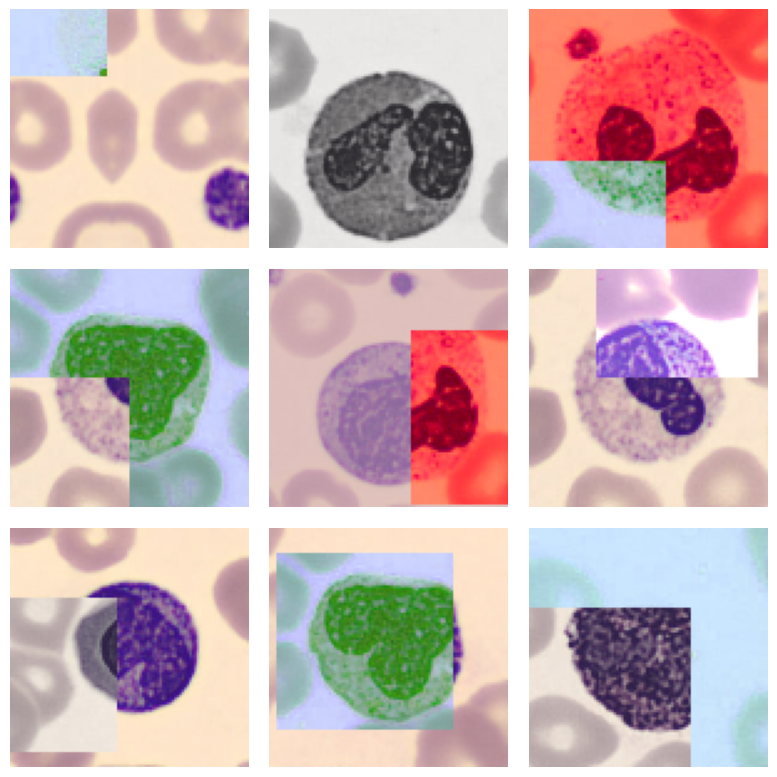

In [14]:
#Additional plot of final result of images
plot_images(X_train, num=9)

# Define Models

In [15]:
# Define the Residual block with configurable parameters
def residual_block(x, filters, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate
):
    # Define the input layer and initial convolutional block
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding='same', name='conv0')(input_layer)
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.Activation('relu', name='act0')(x)

    # Apply residual block and subsequent global pooling and output layer
    x = residual_block(x=x, filters=filters, kernel_size=kernel_size, downsample=False, stack=stack, name='block0')
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dense(output_shape, name='dense')(x)
    x = tfkl.Activation('softmax', name='softmax')(x)

    # Compile the model
    model = tfk.Model(inputs=input_layer, outputs=x, name='architecture')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Display model summary and plot
    model.summary(expand_nested=True, show_trainable=True)
    tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)
    return model

## Summary

Model: "architecture"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv0 (Conv2D)    │ (None, 96, 96,  │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bn0               │ (None, 96, 96,  │       128 │ conv0[0][0]    │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ act0 (Activation) │ (None, 96, 96,  │         0 │ bn0[0][0]      │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_conv1_0    │ (None, 96, 96,  │     9,248 │ act0[0][0]     │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_bn1_0      │ (None, 96, 96,  │       128 │ block0_conv1_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_act1_0     │ (None, 96, 96,  │         0 │ block0_bn1_0[… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_conv2_0    │ (None, 96, 96,  │     9,248 │ block0_act1_0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_bn2_0      │ (None, 96, 96,  │       128 │ block0_conv2_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_add_0      │ (None, 96, 96,  │         0 │ block0_bn2_0[… │   -   │
│ (Add)             │ 32)             │           │ act0[0][0]     │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_act2_0     │ (None, 96, 96,  │         0 │ block0_add_0[… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ gap               │ (None, 32)      │         0 │ block0_act2_0… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense (Dense)     │ (None, 8)       │       264 │ gap[0][0]      │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ softmax           │ (None, 8)       │         0 │ dense[0][0]    │   -   │
│ (Activation)      │                 │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 20,040 (78.28 KB)

 Trainable params: 19,848 (77.53 KB)

 Non-trainable params: 192 (768.00 B)

Model: "architecture"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv0 (Conv2D)    │ (None, 96, 96,  │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bn0               │ (None, 96, 96,  │       128 │ conv0[0][0]    │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ act0 (Activation) │ (None, 96, 96,  │         0 │ bn0[0][0]      │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_conv1_0    │ (None, 96, 96,  │     9,248 │ act0[0][0]     │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_bn1_0      │ (None, 96, 96,  │       128 │ block0_conv1_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_act1_0     │ (None, 96, 96,  │         0 │ block0_bn1_0[… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_conv2_0    │ (None, 96, 96,  │     9,248 │ block0_act1_0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_bn2_0      │ (None, 96, 96,  │       128 │ block0_conv2_… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_add_0      │ (None, 96, 96,  │         0 │ block0_bn2_0[… │   -   │
│ (Add)             │ 32)             │           │ act0[0][0]     │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block0_act2_0     │ (None, 96, 96,  │         0 │ block0_add_0[… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ gap               │ (None, 32)      │         0 │ block0_act2_0… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense (Dense)     │ (None, 8)       │       264 │ gap[0][0]      │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ softmax           │ (None, 8)       │         0 │ dense[0][0]    │   -   │
│ (Activation)      │                 │           │                │       │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 20,040 (78.28 KB)

 Trainable params: 19,848 (77.53 KB)

 Non-trainable params: 192 (768.00 B)

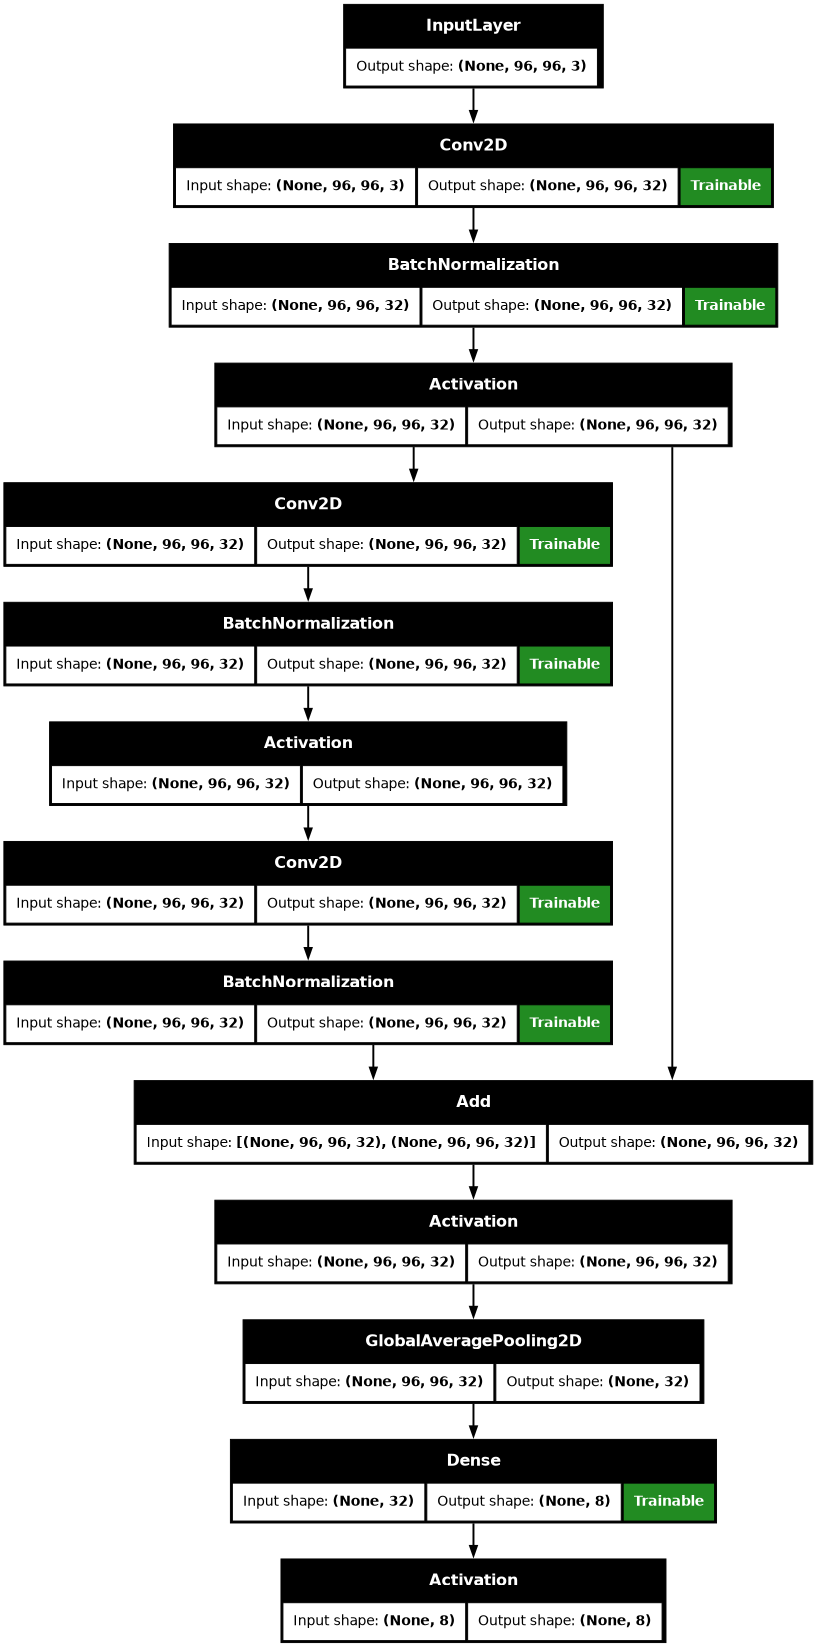

In [16]:
# Build the model with specified input and output shapes
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Early Stopping

In [17]:
# Define the patience value for early stopping
patience = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [18]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size = batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/100


I0000 00:00:1732023467.727367     107 service.cc:145] XLA service 0x56d8476fddc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732023467.727427     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732023467.727432     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 10/299 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1552 - loss: 2.0905

I0000 00:00:1732023471.092930     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.3278 - loss: 1.8649 - val_accuracy: 0.1706 - val_loss: 2.0902
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4063 - loss: 1.7406 - val_accuracy: 0.3541 - val_loss: 1.7863
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4244 - loss: 1.6922 - val_accuracy: 0.2776 - val_loss: 1.9505
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4382 - loss: 1.6506 - val_accuracy: 0.3198 - val_loss: 1.8532
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4566 - loss: 1.6135 - val_accuracy: 0.3390 - val_loss: 1.9101
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4683 - loss: 1.5770 - val_accuracy: 0.3783 - val_loss: 1.8093
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4795 - loss: 1.5464 - val_accuracy: 0.4181 - val_loss: 1.7227
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4971 - loss: 1.5224 - val_accurac

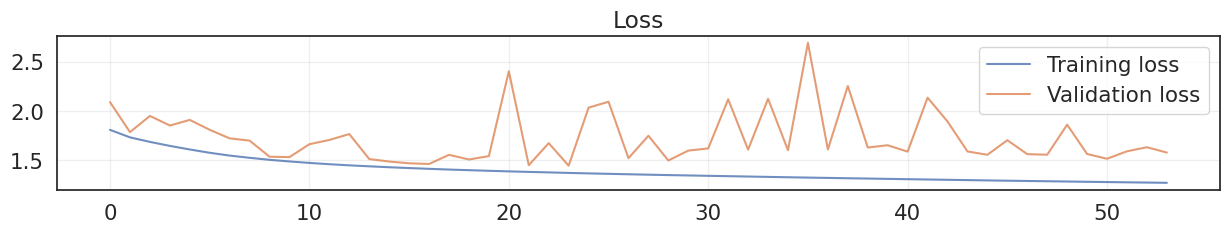

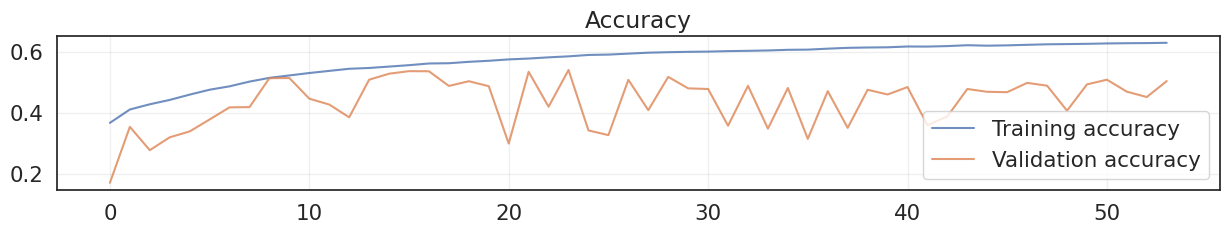

In [19]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


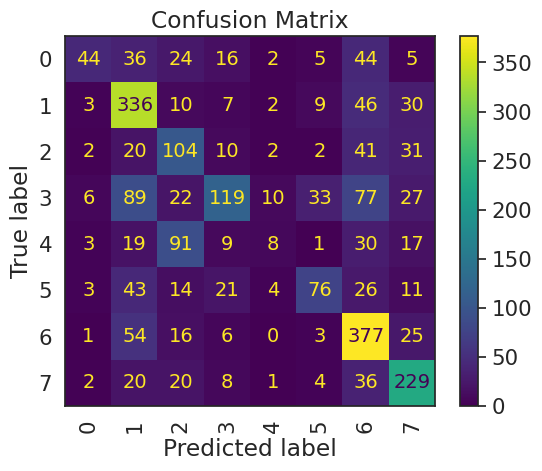

In [22]:
#Print confusion matrix on the validation set
plot_confusion_matrix(model, X_val, y_val)

# Prepare Your Submission

In [23]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must not be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        # Normalizzare le immagini (applicare la divisione per 255)
        if X.max() > 1.0:  # If max value is greater than 1, assume the range is [0, 255]
            X = X / 255.0

        # Fare la previsione con il modello
        preds = self.neural_network.predict(X)

        # Se l'output è in formato one-hot (shape = 2D), prendere l'argmax per ottenere le classi
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)

        return preds

Writing model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)